***Data Source1:  [Foursquare](https://developer.foursquare.com/places) API***

***Data Source2: [Yelp](https://www.yelp.com/developers/documentation/v3/get_started) API***

***Data Source3:  [CityBikes](https://citybik.es/) API***

In [2]:
# imports
import pandas as pd
import requests
import os
import time

# Foursquare

In [3]:
#foursquare requires an authorization key. it is a best prectice to save this key in environment variable
# Lets fetch that key from system using os library
FOURSQUARE_KEY = os.getenv('FOURSQUARE_API_KEY')

***Send a request to Foursquare with a small radius (1000m) for all the bike stations in your city of choice.***

In [299]:
stations_df=pd.read_csv('../data/paris_stations.csv') # load the stations from the csv file
stations_df.head()

,station_id,station,latitude,longitude,no_of_bikes,network_id
0,78ec9186acd18a0b30bd3156d24b9f8d,Benjamin Godard - Victor Hugo,48.865983,2.275725,1,velib
1,43c856353b954711f2bbee185a1f9d04,André Mazet - Saint-André des Arts,48.853756,2.339096,2,velib
2,9b2700f3b19beb1dd9df2fd6a013789f,Faubourg Du Temple - Republique,48.867872,2.364898,5,velib
3,80778031e1a033712bfc3a27a190d5dd,Beaux-Arts - Bonaparte,48.856452,2.334852,1,velib
4,f8f9ec30d28856f9b7fad103be9e4674,Toudouze - Clauzel,48.879296,2.337360,0,velib


In [24]:
def fetch_foursquare(latitude, longitude, radius, api_key): 
    '''
        Funtion to fetch the foursquare places according to latitude and longitude
    '''
    try:
        url = "https://api.foursquare.com/v3/places/search"
        headers = {"accept": "application/json",
               "Authorization": api_key}
        params = {
            "ll": f"{latitude},{longitude}",
            "radius": radius,
            "fields": "fsq_id,name,categories,rating,popularity,price,geocodes",
            "sort": "rating"
        }
        response = requests.get(url, headers=headers,params=params)
        response.raise_for_status()
        return response
    except requests.exceptions.HTTPError as errh:
        print("HTTP Error")
        print(errh.args[0])
   

In [29]:
def fetch_foursquare_of_city():
    ''' 
        Function to iterate all the stations of city Paris and retrive the foursquare places from (fetch_foursquare) function
    '''
    places=pd.DataFrame()
    try:
        temp_counter=0
        for index, row in stations_df.iterrows():
            if temp_counter%20==0:
                time.sleep(2) #wait for 2 sec
            temp_counter=temp_counter+1
            res = fetch_foursquare(latitude=row['latitude'], longitude=row['longitude'], radius=1000, api_key=FOURSQUARE_KEY) 
            df=pd.json_normalize(res.json()['results'])
            df['station']=row['station']
            places=pd.concat([places,df], ignore_index=True)
    except:
        print("Error occured")
    else:
        print("Process Completed")
    return places


In [30]:
places=fetch_foursquare_of_city() #It may takes some time to finish
places.head() 
    

Process Completed


,fsq_id,categories,name,popularity,rating,geocodes.main.latitude,geocodes.main.longitude,geocodes.roof.latitude,geocodes.roof.longitude,price,geocodes.drop_off.latitude,geocodes.drop_off.longitude,station,geocodes.front_door.latitude,geocodes.front_door.longitude
0,4bb381b7eb3e9521d738cb0a,"[{'id': 16041, 'name': 'Plaza', 'icon': {'pref...",Place du Trocadéro,0.999984,9.4,48.861949,2.287887,48.861949,2.287887,NaN,NaN,NaN,Benjamin Godard - Victor Hugo,NaN,NaN
1,5bd848f89de23b003984d7a9,"[{'id': 13236, 'name': 'Italian Restaurant', '...",Marzo Rive Droite,0.969506,9.1,48.867113,2.287484,48.867113,2.287484,2.0,NaN,NaN,Benjamin Godard - Victor Hugo,NaN,NaN
2,4adcda10f964a5209a3521e3,"[{'id': 10027, 'name': 'Museum', 'icon': {'pre...",Musée Marmottan Monet,0.993032,9.1,48.859320,2.267321,48.859254,2.267410,NaN,NaN,NaN,Benjamin Godard - Victor Hugo,NaN,NaN
3,5b61826df193c0002cfec9d5,"[{'id': 13065, 'name': 'Restaurant', 'icon': {...",La Suite Girafe,0.999502,9.0,48.861949,2.287887,48.861949,2.287887,NaN,NaN,NaN,Benjamin Godard - Victor Hugo,NaN,NaN
4,4adcda14f964a5203a3721e3,"[{'id': 13036, 'name': 'Tea Room', 'icon': {'p...",Carette,0.999974,9.0,48.863666,2.287205,48.863666,2.287205,3.0,NaN,NaN,Benjamin Godard - Victor Hugo,NaN,NaN


In [32]:
places.shape

(14580, 15)

***Note:*** 
- We set a sleep time to 2 second to hault the query process after few queries as API have some sort of Rate Limit set.This timer is to make sure our process would not exceed the limit in any case.
- Save this DataFrame into csv file to avoid requering the API again

In [31]:
places.to_csv('../data/raw_places.csv', index=False)

In [33]:
#places=pd.read_csv('../data/raw_places.csv')


***Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)***

In [35]:
places.columns

Index(['fsq_id', 'categories', 'name', 'popularity', 'rating',
       'geocodes.main.latitude', 'geocodes.main.longitude',
       'geocodes.roof.latitude', 'geocodes.roof.longitude', 'price',
       'geocodes.drop_off.latitude', 'geocodes.drop_off.longitude', 'station',
       'geocodes.front_door.latitude', 'geocodes.front_door.longitude'],
      dtype='object')

In [ ]:
# Cleaning places dataset

In [36]:
places.drop(['geocodes.roof.latitude','geocodes.roof.longitude',
             'geocodes.drop_off.latitude', 'geocodes.drop_off.longitude',
             'geocodes.front_door.latitude', 'geocodes.front_door.longitude'], axis=1,inplace=True)

In [38]:
places.rename(columns={'geocodes.main.latitude':'latitude','geocodes.main.longitude':'longitude'},inplace=True)

In [39]:
places.columns

Index(['fsq_id', 'categories', 'name', 'popularity', 'rating', 'latitude',
       'longitude', 'price', 'station'],
      dtype='object')

In [40]:
places.drop_duplicates(subset=places.columns.difference(['station']),inplace=True)# drop the duplicate rows from the dataset

***Note:*** we exclude station column from the duplicates filter as this column is inserted by us therefore could contain diffrent value for duplicate records from the API

In [41]:
places.shape

(2318, 9)

***Note:*** we can see that shape of the places dataset changed drastically. That means most of the records from the API were duplicate.

In [ ]:
# check for missing values

In [42]:
places.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2318 entries, 0 to 14579
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fsq_id      2318 non-null   object 
 1   categories  2318 non-null   object 
 2   name        2318 non-null   object 
 3   popularity  2318 non-null   float64
 4   rating      1621 non-null   float64
 5   latitude    2318 non-null   float64
 6   longitude   2318 non-null   float64
 7   price       917 non-null    float64
 8   station     2318 non-null   object 
dtypes: float64(5), object(4)
memory usage: 181.1+ KB


***Note:*** The above summary shows that the column 'rating' and 'price' have some null values as their non-null count is less than the total no of rows in dataset.
- Also as both of these columns are numeric columns so we can easily fill the missing values with 0

In [43]:
places['rating'].fillna(0,inplace=True) # fill the null value with 0

In [44]:
places['price'].fillna(0,inplace=True)

In [45]:
places.info() #perfect

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2318 entries, 0 to 14579
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fsq_id      2318 non-null   object 
 1   categories  2318 non-null   object 
 2   name        2318 non-null   object 
 3   popularity  2318 non-null   float64
 4   rating      2318 non-null   float64
 5   latitude    2318 non-null   float64
 6   longitude   2318 non-null   float64
 7   price       2318 non-null   float64
 8   station     2318 non-null   object 
dtypes: float64(5), object(4)
memory usage: 181.1+ KB


In [ ]:
#Normalizing the categories as these are in the form of a list in places DF

In [48]:
places['fsq_id'].value_counts() # counts the unique values in a column and group it

4bb381b7eb3e9521d738cb0a    1
52b7fc67498e98b1c15f59cd    1
57122311498e1a08e988a1cf    1
4b8772c8f964a52094bf31e3    1
51c18854498efff560dadcf5    1
                           ..
4bd1726841b9ef3bececfbe5    1
5eb335371e10f900071bd05c    1
5e0b7752ee0f6000087107eb    1
bc8ac35839524d52f0169f9b    1
4b0b081af964a520e42b23e3    1
Name: fsq_id, Length: 2318, dtype: int64

***Note:*** Above output shows that fsq_id is unique throughout the dataset. Therefore we can use it as a key to connect categories with places dataset

In [50]:
fsq_category=places[['fsq_id','categories']].copy()
fsq_category.head()

,fsq_id,categories
0,4bb381b7eb3e9521d738cb0a,"[{'id': 16041, 'name': 'Plaza', 'icon': {'pref..."
1,5bd848f89de23b003984d7a9,"[{'id': 13236, 'name': 'Italian Restaurant', '..."
2,4adcda10f964a5209a3521e3,"[{'id': 10027, 'name': 'Museum', 'icon': {'pre..."
3,5b61826df193c0002cfec9d5,"[{'id': 13065, 'name': 'Restaurant', 'icon': {..."
4,4adcda14f964a5203a3721e3,"[{'id': 13036, 'name': 'Tea Room', 'icon': {'p..."


In [51]:
def dict_list_to_df(dff,col,id_col):
    ''' 
        Function to convert the list of categories into a Dataframe
    '''
    rows = []
    for index, row in dff[col].iteritems():
        for item in list(eval((row))):
            item[id_col]=dff[id_col][index]
            rows.append(item)
    df = pd.DataFrame(rows)
    return df

fsq_category_df = dict_list_to_df(fsq_category,'categories','fsq_id')
fsq_category_df.head()

,id,name,icon,fsq_id
0,16041,Plaza,{'prefix': 'https://ss3.4sqi.net/img/categorie...,4bb381b7eb3e9521d738cb0a
1,13236,Italian Restaurant,{'prefix': 'https://ss3.4sqi.net/img/categorie...,5bd848f89de23b003984d7a9
2,10027,Museum,{'prefix': 'https://ss3.4sqi.net/img/categorie...,4adcda10f964a5209a3521e3
3,13065,Restaurant,{'prefix': 'https://ss3.4sqi.net/img/categorie...,5b61826df193c0002cfec9d5
4,13036,Tea Room,{'prefix': 'https://ss3.4sqi.net/img/categorie...,4adcda14f964a5203a3721e3


In [52]:
fsq_category_df.drop(['icon'],axis=1,inplace=True) # we don't need that column so drop it

In [57]:
fsq_category_df.drop_duplicates(inplace=True)

***Note:*** So now we have all the categories and corresponding 'fsq_id' in dataframe.We will save this in csv file for future use. from this dataset we can query the places and filter them using either category 'id' or 'name'. 'fsq_id' will work as a key to connect 'category' with the 'places' dataset

In [58]:
fsq_category_df.rename(columns={'id':'category_id','name':'category'},inplace=True)

In [59]:
fsq_category_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3258 entries, 0 to 3258
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category_id  3258 non-null   int64 
 1   category     3258 non-null   object
 2   fsq_id       3258 non-null   object
dtypes: int64(1), object(2)
memory usage: 101.8+ KB


In [61]:
fsq_category_df.to_csv('../data/fsq_category.csv', index=False)

***Note:*** We can drop the 'categories' column from 'places' dataframe

In [62]:
places.drop(['categories'],axis=1,inplace=True)

In [63]:
places.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2318 entries, 0 to 14579
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fsq_id      2318 non-null   object 
 1   name        2318 non-null   object 
 2   popularity  2318 non-null   float64
 3   rating      2318 non-null   float64
 4   latitude    2318 non-null   float64
 5   longitude   2318 non-null   float64
 6   price       2318 non-null   float64
 7   station     2318 non-null   object 
dtypes: float64(5), object(3)
memory usage: 227.5+ KB


***Note:*** This is our refined places dataset from the Foursquare API. Save this in a csv

In [64]:
places.to_csv('../data/places.csv', index=False)

***Note:*** lets search for a category and find some features about the places.


In [82]:
#places=pd.read_csv('../data/places.csv')

In [98]:
def search_places(category):
    ''' 
        Function to search the places by particular category
    '''
    temp_cat_df=fsq_category_df[(fsq_category_df['category'].str.contains(category.strip(),case=False)) ]
    search_result = pd.merge(temp_cat_df, places, on='fsq_id') #combine the category detail and places in pne DF
    return search_result
    

In [103]:
category='bar'
search_result=search_places(category)
search_result.head()

,category_id,category,fsq_id,name,popularity,rating,latitude,longitude,price,station
0,13013,Hotel Bar,4b77f147f964a52097af2ee3,Saint-James Club,0.985926,8.7,48.870401,2.279922,3.0,Benjamin Godard - Victor Hugo
1,13025,Wine Bar,4b68a117f964a520c8832be3,Le Barav,0.979990,9.3,48.865121,2.363202,2.0,Faubourg Du Temple - Republique
2,13009,Cocktail Bar,5415ae4f498e9aee38f6a39e,CopperBay,0.979023,9.2,48.869835,2.357114,3.0,Faubourg Du Temple - Republique
3,13025,Wine Bar,548cbfba498e8beca9c22ef9,Le Ballon Rouge,0.972475,9.2,48.867587,2.356783,0.0,Faubourg Du Temple - Republique
4,13059,Juice Bar,5dd296bdd3fbb90007e2e259,Joe & The Juice,0.999604,9.2,48.873729,2.332113,1.0,Toudouze - Clauzel


***Put your parsed results into a DataFrame***

***Note:*** Our result is in 'search_result' DataFrame

# Yelp

***Send a request to Yelp with a small radius (1000m) for all the bike stations in your city of choice.***

In [117]:
YELP_KEY = os.getenv('YELP_API_KEY') #Yelp API key

In [161]:
def fetch_yelp(latitude, longitude, radius, api_key):
    '''
        Funtion to fetch the yelp places according to latitude and longitude
    '''
    #try:
    url = "https://api.yelp.com/v3/businesses/search"
    headers = {"accept": "application/json",
            "Authorization": f"Bearer {api_key}" }
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "radius": radius,
        "limit": 20,
        "sort_by": "rating"
    }
    response = requests.get(url, headers=headers,params=params)
    #response.raise_for_status()
    return response
   # except requests.exceptions.HTTPError as errh:
      #  print("HTTP Error")
      #  print(errh.args[0])

In [207]:
def fetch_yelp_of_city():
    ''' 
        Function to iterate all the stations of city Paris and retrive the Yelp places from (fetch_yelp) function
    '''
    yelp_places=pd.DataFrame()
    #try:
    temp_counter1=0
    for index, row in stations_df.iterrows():
        if temp_counter1%20==0:
            time.sleep(2)
        temp_counter1=temp_counter1+1
    res1 = fetch_yelp(latitude=row['latitude'], longitude=row['longitude'], radius=1000, api_key=YELP_KEY) 
    df1=pd.json_normalize(res1.json()['businesses'])
    df1['station']=row['station']
    yelp_places=pd.concat([yelp_places,df1], ignore_index=True)
    #except:
    #    print("Error occured")
    #else:
   #     print("Process Completed")
    return yelp_places


In [166]:
yelp_places=pd.DataFrame()

In [208]:
yelp_places=fetch_yelp_of_city()
yelp_places.head()

In [209]:
yelp_places.shape

(2503, 25)

In [210]:
yelp_places.to_csv('../data/raw_yelp_places.csv', index=False)

In [220]:
#yelp_places=pd.read_csv('../data/raw_yelp_places.csv')

In [ ]:
#explore and clean yelp_places dataset

In [221]:
yelp_places.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address,price,station
0,JNbPJxM07pzJ-6JiXkZu6g,la-galerie-dior-paris,La Galerie Dior,https://s3-media4.fl.yelpcdn.com/bphoto/YOFtdj...,False,https://www.yelp.com/biz/la-galerie-dior-paris...,9.0,"[{'alias': 'museums', 'title': 'Museums'}, {'a...",5.0,[],...,11 Rue François 1er,NaN,NaN,Paris,75008.0,FR,NaN,"['11 Rue François 1er', '75008 Paris', 'France']",NaN,Boétie - Ponthieu
1,3zZOFdwxA_JDcAKEKomknA,merci-jérôme-paris-12,Merci Jérôme,https://s3-media1.fl.yelpcdn.com/bphoto/okW5Ok...,False,https://www.yelp.com/biz/merci-j%C3%A9r%C3%B4m...,5.0,"[{'alias': 'bakeries', 'title': 'Bakeries'}, {...",5.0,[],...,270 rue du Faubourg Saint-Honoré,NaN,NaN,Paris,75008.0,FR,75.0,"['270 rue du Faubourg Saint-Honoré', '75008 Pa...",NaN,Boétie - Ponthieu
2,pjuZB_Qf-bFzvLDiEqApjA,helen-paris,Helen,https://s3-media3.fl.yelpcdn.com/bphoto/ks8vNi...,False,https://www.yelp.com/biz/helen-paris?adjust_cr...,5.0,"[{'alias': 'french', 'title': 'French'}, {'ali...",5.0,[],...,3 rue Berryer,NaN,NaN,Paris,75008.0,FR,75.0,"['3 rue Berryer', '75008 Paris', 'France']",€€€€,Boétie - Ponthieu
3,zpRDPVf_Izk5B7foS9yd8Q,le-colisée-paris-2,Le Colisée,https://s3-media1.fl.yelpcdn.com/bphoto/FeCNMC...,False,https://www.yelp.com/biz/le-colis%C3%A9e-paris...,6.0,"[{'alias': 'french', 'title': 'French'}, {'ali...",5.0,[],...,17 rue du Colisée,NaN,NaN,Paris,75008.0,FR,75.0,"['17 rue du Colisée', '75008 Paris', 'France']",NaN,Boétie - Ponthieu
4,7bHtpYzGmCrvvXGWmnszNQ,la-cour-jardin-paris,La Cour Jardin,https://s3-media2.fl.yelpcdn.com/bphoto/t4GAXD...,False,https://www.yelp.com/biz/la-cour-jardin-paris?...,5.0,"[{'alias': 'french', 'title': 'French'}]",5.0,[],...,25 avenue Montaigne,NaN,NaN,Paris,75008.0,FR,75.0,"['25 avenue Montaigne', '75008 Paris', 'France']",NaN,Boétie - Ponthieu


In [ ]:
# Drop the unneccesary columns 

In [222]:
yelp_places.columns

Index(['id', 'alias', 'name', 'image_url', 'is_closed', 'url', 'review_count',
       'categories', 'rating', 'transactions', 'phone', 'display_phone',
       'distance', 'coordinates.latitude', 'coordinates.longitude',
       'location.address1', 'location.address2', 'location.address3',
       'location.city', 'location.zip_code', 'location.country',
       'location.state', 'location.display_address', 'price', 'station'],
      dtype='object')

In [223]:
yelp_places.drop(columns=['alias','image_url', 'is_closed', 'url','transactions', 'phone', 'display_phone','distance',
                          'location.address1', 'location.address2', 'location.address3',
                          'location.city', 'location.zip_code', 'location.country',
                          'location.state', 'location.display_address'
                         ],inplace=True)


In [244]:
yelp_places.astype(str).drop_duplicates(subset=yelp_places.columns.difference(['station']),inplace=True)# drop the duplicate rows from the dataset

In [225]:
yelp_places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2503 entries, 0 to 2502
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2503 non-null   object 
 1   name                   2503 non-null   object 
 2   review_count           2503 non-null   float64
 3   categories             2503 non-null   object 
 4   rating                 2503 non-null   float64
 5   coordinates.latitude   2503 non-null   float64
 6   coordinates.longitude  2503 non-null   float64
 7   price                  1415 non-null   object 
 8   station                2503 non-null   object 
dtypes: float64(4), object(5)
memory usage: 176.1+ KB


In [237]:
yelp_places.rename(columns={'coordinates.latitude':'latitude','coordinates.longitude':'longitude'},inplace=True)

In [226]:
# Above summary shows price have sum null values. Fill these with 0
yelp_places['price'].fillna(0,inplace=True)

***Note:*** Here we exclude 'station' from the duplicate check. 
- We choose 'station' for the same reason as in case of Foursquare API

In [227]:
# Normalize the categories

In [229]:
yelp_category=yelp_places[['id','categories']]
yelp_category.head()

,id,categories
0,JNbPJxM07pzJ-6JiXkZu6g,"[{'alias': 'museums', 'title': 'Museums'}, {'a..."
1,3zZOFdwxA_JDcAKEKomknA,"[{'alias': 'bakeries', 'title': 'Bakeries'}, {..."
2,pjuZB_Qf-bFzvLDiEqApjA,"[{'alias': 'french', 'title': 'French'}, {'ali..."
3,zpRDPVf_Izk5B7foS9yd8Q,"[{'alias': 'french', 'title': 'French'}, {'ali..."
4,7bHtpYzGmCrvvXGWmnszNQ,"[{'alias': 'french', 'title': 'French'}]"


In [230]:
yelp_category = dict_list_to_df(yelp_category,'categories','id')
yelp_category

,alias,title,id
0,museums,Museums,JNbPJxM07pzJ-6JiXkZu6g
1,arttours,Art Tours,JNbPJxM07pzJ-6JiXkZu6g
2,fashion,Fashion,JNbPJxM07pzJ-6JiXkZu6g
3,bakeries,Bakeries,3zZOFdwxA_JDcAKEKomknA
4,breakfast_brunch,Breakfast & Brunch,3zZOFdwxA_JDcAKEKomknA
...,...,...,...
3664,parks,Parks,L4tYXryUg-uYk6fsU2qVNQ
3665,auto,Automotive,lmvpdXnfgz6k5NMmX-zwxg
3666,bars,Bars,lmvpdXnfgz6k5NMmX-zwxg
3667,trainstations,Train Stations,lmvpdXnfgz6k5NMmX-zwxg


In [231]:
yelp_category.rename(columns={'alias':'category_alias','title':'category_title'},inplace=True)

In [257]:
yelp_category.drop_duplicates(inplace=True)

In [258]:
yelp_category.to_csv('../data/yelp_category.csv', index=False) #save to csv file

In [233]:
#yelp_category=pd.read_csv('../data/yelp_category.csv')

In [234]:
yelp_places.drop(['categories'],axis=1,inplace=True) #Drop category from yelp_places as now these are in yelp_category DF

In [252]:
yelp_places.drop_duplicates(subset=yelp_places.columns.difference(['station']),inplace=True)

In [254]:
yelp_places.info() #data is cleaned from null values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176 entries, 0 to 2502
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            1176 non-null   object 
 1   name          1176 non-null   object 
 2   review_count  1176 non-null   float64
 3   rating        1176 non-null   float64
 4   latitude      1176 non-null   float64
 5   longitude     1176 non-null   float64
 6   price         1176 non-null   object 
 7   station       1176 non-null   object 
dtypes: float64(4), object(4)
memory usage: 82.7+ KB


In [255]:
yelp_places.to_csv('../data/yelp_places.csv', index=False) #save for later use

***Note:*** Above process is similar to the process followed for Foursquare API 

Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)

In [87]:
#yelp_places=pd.read_csv('../data/yelp_places.csv')

In [241]:
def search_yelp_places(category):
    temp_cat_df1=yelp_category[(yelp_category['category_alias'].str.contains(category.strip(),case=False)) |
                               (yelp_category['category_title'].str.contains(category.strip(),case=False)) ]
    search_yelp_result = pd.merge(temp_cat_df1, yelp_places, on='id')
    return search_yelp_result

In [259]:
#Search places according to category
category1='bar'
search_result1=search_yelp_places(category1)
search_result1.head()

,category_alias,category_title,id,name,review_count,rating,latitude,longitude,price,station
0,cocktailbars,Cocktail Bars,G2OzmHeJnDaQwXsFBRYC3g,Les Ambassadeurs,9.0,5.0,48.867300,2.321130,0,Boétie - Ponthieu
1,champagne_bars,Champagne Bars,G2OzmHeJnDaQwXsFBRYC3g,Les Ambassadeurs,9.0,5.0,48.867300,2.321130,0,Boétie - Ponthieu
2,sushi,Sushi Bars,GzWfXIXbGwacNHfJZyr-aw,Sushi Okuda,4.0,5.0,48.867095,2.302471,0,Boétie - Ponthieu
3,beerbar,Beer Bar,NEEgRG1lU4yb4RfugrR43A,Tony,7.0,5.0,48.872910,2.354240,€€,Jemmapes - Ecluses Saint-Martin
4,cocktailbars,Cocktail Bars,NEEgRG1lU4yb4RfugrR43A,Tony,7.0,5.0,48.872910,2.354240,€€,Jemmapes - Ecluses Saint-Martin


***Put your parsed results into a DataFrame***

***Note:*** Our result is in 'search_result1' DataFrame

# Comparing Results

***Which API provided you with more complete data? Provide an explanation. ***

- No doubt both the APIs gives the similar type of information about a place
- But in Foursquare we have the flexibility to filter out only the required fields while initializing a request. Which helps alot and saves time and resources.


- If we see overall Foursquare API provides more no of records as compare to Yelp API

In [261]:
print('Foursquare places ',places.shape)
print('Yelp places ',yelp_places.shape)

Foursquare places  (2318, 8)
Yelp places  (1176, 8)


- Yelp provides only limited no of fields.On the other hand Foursquare provides vast range of fields including the 
more in-depth fields like chains,related_places etc

In [276]:
#compare the ratings of the stations
merge_APIS = pd.merge(places[['rating','station']], yelp_places[['rating','station']], on='station')
merge_APIS.drop_duplicates(inplace=True)
merge_APIS.head(10)

,rating_x,station,rating_y
0,9.2,Boétie - Ponthieu,5.0
20,9.1,Boétie - Ponthieu,5.0
80,8.8,Pajol - Place Herbert,5.0
81,8.8,Pajol - Place Herbert,4.5
97,8.8,Pajol - Place Herbert,4.0
100,8.6,Pajol - Place Herbert,5.0
101,8.6,Pajol - Place Herbert,4.5
117,8.6,Pajol - Place Herbert,4.0
120,8.4,Pajol - Place Herbert,5.0
121,8.4,Pajol - Place Herbert,4.5


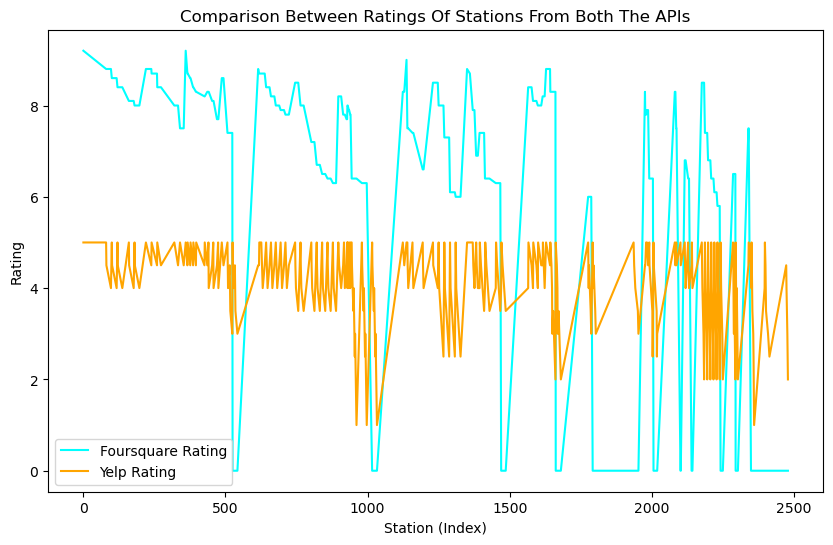

In [297]:
# Plot this comparison
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
y1=merge_APIS['rating_x'] # Foursquare places
y2=merge_APIS['rating_y'] # yelp places
x=merge_APIS.index # we use index only just to compare two ratings with each other

# plot data in line chart
plt.plot(x, y1,  color='cyan')
plt.plot(x, y2,  color='orange')
plt.xlabel("Station (Index)")
plt.ylabel("Rating")
plt.legend(["Foursquare Rating", "Yelp Rating"])
plt.title("Comparison Between Ratings Of Stations From Both The APIs")
plt.show()

***Note:*** Both the ratings have different boundry limits.But the graph shows that Yelp have more information about the ratings as compare to Foursquare beacuse line for Yelp is more tightly stacked

***Result:*** 
- So the data in Yelp provides the more coverage.
- Foursquare API does not provide the review detail

***Get the top 10 restaurants according to their rating***

-Foursuare API

In [265]:
category='restaurant'
search_result=search_places(category)
search_result.loc[0:9].sort_values(by='rating',ascending=False)

,category_id,category,fsq_id,name,popularity,rating,latitude,longitude,price,station
5,13065,Restaurant,5b394cae92e7a9002c724cf9,La Maison d'Isabelle,0.998147,9.4,48.849807,2.348409,1.0,André Mazet - Saint-André des Arts
8,13322,Peruvian Restaurant,5d6ae3b0ca1763000823441b,Coya Paris,0.996460,9.3,48.854281,2.324369,2.0,Beaux-Arts - Bonaparte
6,13065,Restaurant,4b5eec5df964a520129e29e3,Du Pain et des Idées,0.996735,9.2,48.871214,2.362942,2.0,Faubourg Du Temple - Republique
7,13065,Restaurant,548cbfba498e8beca9c22ef9,Le Ballon Rouge,0.972475,9.2,48.867587,2.356783,0.0,Faubourg Du Temple - Republique
9,13065,Restaurant,4d541304d4a6721e9b5691ac,Boulangerie Alexine,0.989563,9.2,48.886093,2.334619,1.0,Toudouze - Clauzel
0,13236,Italian Restaurant,5bd848f89de23b003984d7a9,Marzo Rive Droite,0.969506,9.1,48.867113,2.287484,2.0,Benjamin Godard - Victor Hugo
1,13065,Restaurant,5b61826df193c0002cfec9d5,La Suite Girafe,0.999502,9.0,48.861949,2.287887,0.0,Benjamin Godard - Victor Hugo
2,13145,Fast Food Restaurant,4adcda14f964a5203a3721e3,Carette,0.999974,9.0,48.863666,2.287205,3.0,Benjamin Godard - Victor Hugo
3,13068,American Restaurant,4d59643f296d5481838b58b1,Schwartz's,0.996604,8.8,48.863709,2.285596,2.0,Benjamin Godard - Victor Hugo
4,13148,French Restaurant,4bf54e03ff90c9b68b2d5628,Le Petit Rétro,0.964768,8.7,48.868750,2.284861,3.0,Benjamin Godard - Victor Hugo


- Yelp API

In [266]:
search_result1=search_yelp_places(category)
search_result1.loc[0:9].sort_values(by='rating',ascending=False)

,category_alias,category_title,id,name,review_count,rating,latitude,longitude,price,station
0,restaurants,Restaurants,vS9_lZDvPPkoQndrqKo79Q,HABILE.,6.0,5.0,48.869650,2.360670,0,Jemmapes - Ecluses Saint-Martin
2,restaurants,Restaurants,l71FXlZrExpRs5RqX9Ty-A,Petrus Exploitation,5.0,5.0,48.885220,2.296530,0,Anatole France - Louise Michel
3,restaurants,Restaurants,LYxAyKTwXol9figyY3A6qA,Muraille d'or,2.0,5.0,48.902193,2.385702,0,Bordier - Félix Faure
4,restaurants,Restaurants,uBDdjVzoiMzQ9e19PDkyvQ,Espace Vert,1.0,5.0,48.903220,2.392380,0,Bordier - Félix Faure
5,restaurants,Restaurants,qovtaOGnFK4c3KpADY9ezg,Café Henri,1.0,5.0,48.901620,2.389120,0,Bordier - Félix Faure
1,restaurants,Restaurants,pf4wbF0FiRkgkrJY6nCCyQ,Thai 18,6.0,4.5,48.890030,2.360210,€€,Pajol - Place Herbert
6,restaurants,Restaurants,F0Ba9IJc78CHd8LcIU_z9w,Akasaka,11.0,4.5,48.858320,2.280500,€€€€,Flandrin - Henri Martin
7,restaurants,Restaurants,2V2yDdQdf7xPu4gdZt8Tjw,Amira chicha,1.0,4.0,48.911856,2.333764,0,Carrefour Pleyel
8,restaurants,Restaurants,lc41IrM0HbxYR69YmIePaA,Cafe Loom,1.0,4.0,48.911856,2.333764,0,Carrefour Pleyel
9,restaurants,Restaurants,Sj9cEeQ8ATTL32TXQLU_mQ,Le Casino,2.0,4.0,48.820050,2.477030,0,Place de Verdun
